# Transfer Learning

### Import Libraries

In [12]:
import numpy as np
import cv2
import time
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

import tf_keras as tfk                          # needed due to incompatability with tensorflow_hub version
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



### Import Model

In [13]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"      # mobileNetV2
# inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"        # inceptionNetV3

classifier_model = mobilenet_v2     # choose model that will be used for transfer learning

IMAGE_SHAPE = (224, 224)            # shape of the images that will be used

# instantiate classifier model
classifier = tfk.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))  # Specifies the input shape as (224, 224, 3) to match the 3 channels (RGB)
])

In [14]:
classifier.summary()    # summary of the model architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [15]:
# import imageNet labels (dataset that mobileNet was originally trained on)
labels_path = tfk.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels[645:655]    # A quick check to inspect some labels from the file and make sure it was imported correctly

array(['matchstick', 'maypole', 'maze', 'measuring cup', 'medicine chest',
       'megalith', 'microphone', 'microwave', 'military uniform',
       'milk can'], dtype='<U30')

## Train with MonkeyPox Dataset

### Hyperparameters

In [16]:
import pathlib

data_root = pathlib.Path("../data/Augmented_Images")    # points to the folder containing the images that will be used for training

batch_size = 32
img_height = 224
img_width = 224

### Training and Validations datasets

In [17]:
# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),                         # loads images from the data_root directory
  validation_split=0.2,                   # the dataset is split into training and validation sets using an 80-20 split
  subset="training",                      # set this as the training split
  seed=123,                               # sets a seed for reproducibility in splitting the data
  image_size=(img_height, img_width),     # resizes all images to (224, 224) pixels
  batch_size=batch_size
)
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),                         # loads images from the data_root directory
  validation_split=0.2,                   # the dataset is split into training and validation sets using an 80-20 split
  subset="validation",                    # set this as the validation split
  seed=123,                               # sets a seed for reproducibility in splitting the data
  image_size=(img_height, img_width),     # resizes all images to (224, 224) pixels
  batch_size=batch_size
)

Found 3192 files belonging to 2 classes.
Using 2554 files for training.
Found 3192 files belonging to 2 classes.
Using 638 files for validation.


In [18]:
class_names = np.array(train_ds.class_names)    # class labels for Monkeypox dataset
print(class_names)

['Monkeypox' 'Others']


### Testing before transfer learning is performed

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)           # normalize pixel values of images from [0, 255] to [0, 1] by dividing
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # normalize training split where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))     # normalize validation split where x—images, y—labels.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
# prefetch data to improve performance by overlapping data preprocessing and model execution and cache the dataset in memory
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# sanity check by iterating through the train_ds dataset to inspect the shapes of the images and labels in a batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [21]:
# uses the pre-trained MobileNetV2 model to make predictions on the training dataset before transfer learning
result_batch = classifier.predict(train_ds)

# find the index of the highest predicted value for each image and match it with the image
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]  
predicted_class_names

80/80 [==============================] - 14s 171ms/step


array(['chiton', 'velvet', 'hog', ..., 'Band Aid', 'hog', 'velvet'],
      dtype='<U30')

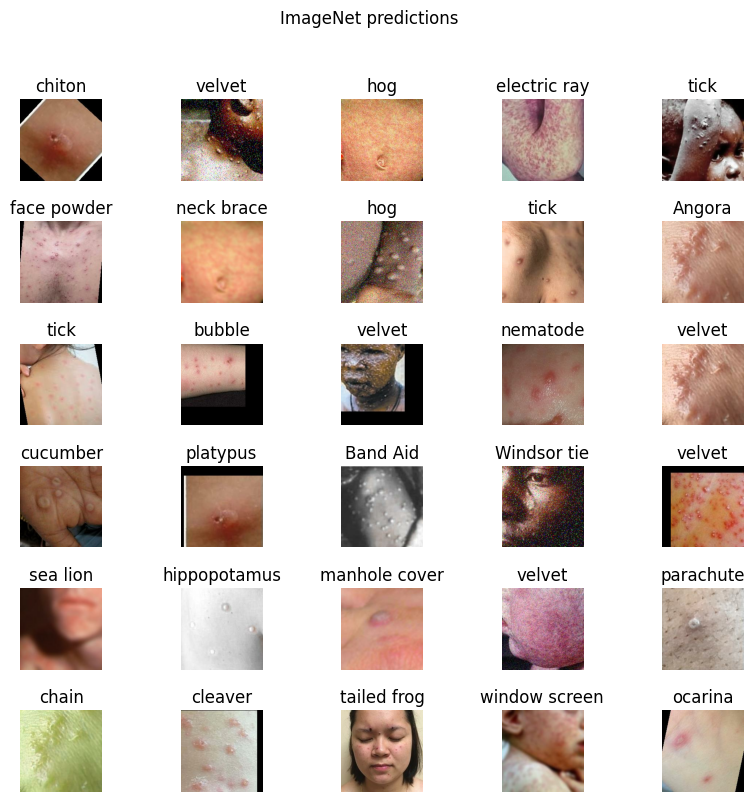

In [22]:
# plot of predictions made by the model before transfer learning
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Download model without final layer

In [24]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"     # mobileNetV2
# inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"     # inceptionNetV3

feature_extractor_model = mobilenet_v2      

# instantiate feature extractor layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [25]:
num_classes = len(class_names)

# instantiate model
model = tfk.Sequential([
  feature_extractor_layer,
  tfk.layers.Dense(num_classes)
])

model.summary()   # summary of the model architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Training 

In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, ConfusionMatrixDisplay

# Define the base path for saving models
save_dir = "../saved_models"
os.makedirs(save_dir, exist_ok=True)

# List to store accuracy results for comparison
model_performance = []

# Parameters
NUM_MODELS = 2
NUM_EPOCHS = 2  # Or any number of epochs you prefer

# TODO: Add function for custom configurations (eg. different optimizer, learning rate, etc.)

# configurations that will be used in training
# configs = [
#     {"learning_rate": 0.001, "optimizer": "adam", "epochs": 3},
#     {"learning_rate": 0.0001, "optimizer": "adam", "epochs": 50},
#     {"learning_rate": 0.001, "optimizer": "sgd", "epochs": 50},
#     {"learning_rate": 0.0001, "optimizer": "sgd", "epochs": 50},
# ]

for i in range(NUM_MODELS):
    print(f"Training model {i + 1}/{NUM_MODELS}")

    # Create subdirectory for this model
    model_subdir = os.path.join(save_dir, f"model_{i + 1}")
    os.makedirs(model_subdir, exist_ok=True)

    # Recreate the model architecture for each loop iteration
    feature_extractor_layer = hub.KerasLayer(
        feature_extractor_model,
        input_shape=(224, 224, 3),
        trainable=False)

    model = tfk.Sequential([
        feature_extractor_layer,
        tfk.layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=tfk.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

    # Save the model
    model_path = os.path.join(model_subdir, f"model_{i + 1}.h5")
    model.save(model_path)
    
    # Save training history for analysis later
    history_path = os.path.join(model_subdir, f"history_{i + 1}.npy")
    np.save(history_path, history.history)

    # Save metrics and plots as PNGs

    # Confusion Matrix
    val_predictions = model.predict(val_ds)
    val_predicted_ids = np.argmax(val_predictions, axis=-1)
    true_labels = np.concatenate([y for x, y in val_ds], axis=0)

    cm = confusion_matrix(true_labels, val_predicted_ids)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    confusion_matrix_path = os.path.join(model_subdir, "confusion_matrix.png")
    plt.savefig(confusion_matrix_path)
    plt.close()

    # Training and Validation Loss Curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join(model_subdir, "loss_curve.png")
    plt.savefig(loss_curve_path)
    plt.close()

    # Bar Chart of Model Evaluation Metrics
    accuracy = history.history['val_accuracy'][-1]
    sensitivity = recall_score(true_labels, val_predicted_ids, average='macro')
    specificity = np.mean(np.diag(cm) / (np.diag(cm) + np.sum(cm, axis=0) - np.diag(cm)))
    f1 = f1_score(true_labels, val_predicted_ids, average='macro')

    metrics = {
        "Accuracy": accuracy,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity,
        "F1-Score": f1
    }

    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values(), color=['darkturquoise', 'sandybrown', 'hotpink', 'limegreen'])
    plt.title("Model Evaluation Metrics")
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel("Score")
    bar_chart_path = os.path.join(model_subdir, "evaluation_metrics.png")
    plt.savefig(bar_chart_path)
    plt.close()

    # Classification Report
    class_report = classification_report(true_labels, val_predicted_ids, target_names=class_names, digits=4)
    classification_report_path = os.path.join(model_subdir, "classification_report.txt")
    with open(classification_report_path, "w") as f:
        f.write(class_report)

    # Record the final validation accuracy for comparison
    final_val_acc = history.history['val_accuracy'][-1]
    model_performance.append((model_path, final_val_acc))

    print(f"Model {i + 1} saved to {model_path} with validation accuracy: {final_val_acc:.4f}")

# After the loop, print out the results for comparison
model_performance.sort(key=lambda x: x[1], reverse=True)
print("\nModels ranked by validation accuracy:")
for i, (model_path, accuracy) in enumerate(model_performance):
    print(f"Model {i + 1}: {model_path}, Validation Accuracy: {accuracy:.4f}")


Training model 1/2



80/80 [==============================] - 28s 304ms/step - loss: 0.5143 - accuracy: 0.7584 - val_loss: 0.3991 - val_accuracy: 0.8307


c:\Users\jacob\anaconda3\envs\capstone\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 12s 543ms/step
Model 1 saved to ../saved_models\model_1\model_1.h5 with validation accuracy: 0.8307
Training model 2/2
80/80 [==============================] - 49s 529ms/step - loss: 0.4995 - accuracy: 0.7596 - val_loss: 0.3950 - val_accuracy: 0.8276


c:\Users\jacob\anaconda3\envs\capstone\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 12s 532ms/step
Model 2 saved to ../saved_models\model_2\model_2.h5 with validation accuracy: 0.8276

Models ranked by validation accuracy:
Model 1: ../saved_models\model_1\model_1.h5, Validation Accuracy: 0.8307
Model 2: ../saved_models\model_2\model_2.h5, Validation Accuracy: 0.8276


## Testing

In [39]:
model.compile(
  optimizer=tfk.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [ ]:
NUM_EPOCHS = 5

# train model
trained_model = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

### Predictions

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")